In [19]:
import numpy as np 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras import layers,models, Sequential
from pathlib import Path
from modules.data_handler import Dataset
import keras_tuner as kt
from keras_tuner import Hyperband
from keras import regularizers
import yaml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import logging
import h5py
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
logging.basicConfig(level=logging.INFO)
import joblib

Read in data as a dataset

In [20]:
ds_0D = Dataset(Path("./input/0D.csv"))
ds_0E = Dataset(Path("./input/0E.csv"))
ds_1D = Dataset(Path("./input/1D.csv"))
ds_1E = Dataset(Path("./input/1E.csv"))
ds_2D = Dataset(Path("./input/2D.csv"))
ds_2E = Dataset(Path("./input/2E.csv"))
ds_3D = Dataset(Path("./input/3D.csv"))
ds_3E = Dataset(Path("./input/3E.csv"))
ds_4D = Dataset(Path("./input/4D.csv"))
ds_4E = Dataset(Path("./input/4E.csv"))

Create Dictonary to go through datasets more easily

In [21]:
name_dict = {
    "ds_0D": ds_0D,
    "ds_0E": ds_0E,
    "ds_1D": ds_1D,
    "ds_1E": ds_1E,
    "ds_2D": ds_2D,
    "ds_2E": ds_2E,
    "ds_3D": ds_3D,
    "ds_3E": ds_3E,
    "ds_4D": ds_4D,
    "ds_4E": ds_4E,
}

Eliminate all data where V_in = 0 -> There is very high vibrating data there which could interfere.

In [ ]:
for name, df in name_dict.items():
    if 'V_in' in df.data.columns:
        df.apply_threshold(threshold=0, column="V_in",mode="le",reset_index=True)
        logging.info(f"Processed {name}: Applied threshold.")
    else:
        logging.warning(f"Skipped {name}: 'V_in' column not found.")

Delete the first vibration data, as it is jerky and may interfere with training

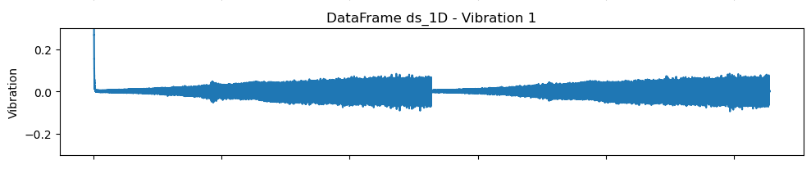

In [ ]:
columns = ["Vibration_1", "Vibration_2", "Vibration_3"]
for name, df in name_dict.items():
    logging.info(f"Processing Dataset {name}")
    for column in columns:
        max_value = df.data[column].iloc[12500:].max()  
        threshold = max_value + (max_value / 3)       
        df.apply_threshold(threshold=threshold, column=column, mode="ge", reset_index=True)

Create two further columns which are used for prediction. One is whether there is an imbalance and the other is how strong this imbalance is

In [ ]:
for name, df in name_dict.items(): 
    try:
        df.add_centrifugal_force()
        df.add_unbalance()
        print(f'Name {name}')
    except KeyError as e:
        logging.info(f'Error in {name}: {e}')

_________________________________________________________________________________________________________

Exemplary visualization of the data on selected data sets

In [ ]:
display(ds_0D.data)

In [ ]:
ds_0D.data.describe()

Create Histograms 

In [ ]:
def create_hist(name_dict: dict):
    subplot_counter=len(name_dict)
    fig, axes = plt.subplots(subplot_counter, 1, figsize=(10, subplot_counter * 2), sharex=True)
    for i,(name,df) in enumerate(name_dict.items()):
    # Plot für Vibration_1
        axes[i].plot(range(len(df.data["Vibration_1"])), df.data["Vibration_1"])
        axes[i].set_title(f'DataFrame {name} - Vibration 1')
        axes[i].set_ylim(-0.3, 0.3)
        axes[i].set_ylabel("Vibration")
        

        
        
    plt.tight_layout()
    plt.grid()
    plt.show()
    
create_hist(name_dict)

In [ ]:
ds_1D.data.hist(bins=1000, figsize=(15, 10))
plt.tight_layout()
plt.show()

Create Boxplots

In [ ]:
def create_boxplots(data, ncols=3, figsize_scale=(4, 5)):

    box_plot_data = data.fillna(data.mean())
    box_plot_data = box_plot_data.select_dtypes(include=[np.number])
    num_columns = len(box_plot_data.columns)
    nrows = (num_columns // ncols) + int(num_columns % ncols != 0)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                             figsize=(ncols * figsize_scale[0], nrows * figsize_scale[1]))
    if nrows == 1:
        axes = np.expand_dims(axes, axis=0)
    if ncols == 1:
        axes = np.expand_dims(axes, axis=1)
    for i, column in enumerate(box_plot_data.columns):
        ax = axes[i // ncols, i % ncols]  # Bestimme die Zeile (i//ncols) und Spalte (i%ncols)
        sns.boxplot(data=box_plot_data, y=column, ax=ax, orient='v')
        ax.set_title(f"Boxplot of {column}")
        ax.set_ylabel('Value')
    for i in range(num_columns, nrows * ncols):
        fig.delaxes(axes[i // ncols, i % ncols])

    plt.tight_layout()
    plt.show()
    
create_boxplots(ds_1D.data)


Create correlation matrix

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(ds_1D.data.corr(numeric_only=True), cmap="YlGnBu", annot=False,square=True)
plt.show()

_________________________________________________________________________________________________________

Split data into features and labels

In [31]:
#Split data into features and labels, each in time series
# with 4096 values (1 second) ->Paper
n_samples = 4096

def features_lables (vibration_1,vibration_2,vibration_3,rpm,unbalance,centri_force):
    length = int(np.floor(len(vibration_1)/n_samples))
    
    vibration_1 = np.array(vibration_1)
    vibration_2 = np.array(vibration_2)
    vibration_3 = np.array(vibration_3)
    rpm = np.array(rpm)
    unbalance= np.array(unbalance, dtype=int) #x
    centri_force = np.array(centri_force, dtype=float)
    
    vibration_1 = vibration_1[:int(length )*n_samples]
    vibration_2 = vibration_2[:int(length )*n_samples]
    vibration_3 = vibration_3[:int(length )*n_samples]
    rpm = rpm[:int(length )*n_samples]
    unbalance = unbalance[:length  * n_samples] #x
    centri_force = centri_force[:length * n_samples]
    
    vibration_1 = vibration_1.reshape((length ,n_samples))
    vibration_2 = vibration_2.reshape((length ,n_samples))
    vibration_3 = vibration_3.reshape((length ,n_samples))
    rpm = rpm.reshape((length ,n_samples))
    unbalance = unbalance.reshape(length,n_samples) #x
    centri_force = centri_force.reshape((length, n_samples))
    
    X= np.stack([vibration_1,vibration_2,vibration_3,rpm],axis=-1)
    
    y_centri_force = np.mean(centri_force, axis=1)  
    
    
    y_unbalance = np.any(unbalance, axis=1).astype(int)      
                            
    
    
    return X,y_unbalance,y_centri_force


ds_0D_X, ds_0D_y,ds_0D_y_ce = features_lables(ds_0D.data['Vibration_1'], ds_0D.data['Vibration_2'], ds_0D.data['Vibration_3'], ds_0D.data['Measured_RPM'], ds_0D.data['unbalance'],ds_0D.data['CentriForce'])
ds_1D_X, ds_1D_y,ds_1D_y_ce = features_lables(ds_1D.data['Vibration_1'], ds_1D.data['Vibration_2'], ds_1D.data['Vibration_3'], ds_1D.data['Measured_RPM'], ds_1D.data['unbalance'],ds_1D.data['CentriForce'])
ds_2D_X, ds_2D_y,ds_2D_y_ce = features_lables(ds_2D.data['Vibration_1'], ds_2D.data['Vibration_2'], ds_2D.data['Vibration_3'], ds_2D.data['Measured_RPM'], ds_2D.data['unbalance'],ds_2D.data['CentriForce'])
ds_3D_X, ds_3D_y,ds_3D_y_ce = features_lables(ds_3D.data['Vibration_1'], ds_3D.data['Vibration_2'], ds_3D.data['Vibration_3'], ds_3D.data['Measured_RPM'],ds_3D.data['unbalance'],ds_3D.data['CentriForce'])
ds_4D_X, ds_4D_y,ds_4D_y_ce = features_lables(ds_4D.data['Vibration_1'], ds_4D.data['Vibration_2'], ds_4D.data['Vibration_3'], ds_4D.data['Measured_RPM'], ds_4D.data['unbalance'],ds_4D.data['CentriForce'])


ds_0E_X, ds_0E_y,ds_0E_y_ce = features_lables(ds_0E.data['Vibration_1'], ds_0E.data['Vibration_2'], ds_0E.data['Vibration_3'], ds_0E.data['Measured_RPM'], ds_0E.data['unbalance'],ds_0E.data['CentriForce'])
ds_1E_X, ds_1E_y,ds_1E_y_ce  = features_lables(ds_1E.data['Vibration_1'], ds_1E.data['Vibration_2'], ds_1E.data['Vibration_3'], ds_1E.data['Measured_RPM'], ds_1E.data['unbalance'],ds_1E.data['CentriForce'])
ds_2E_X, ds_2E_y,ds_2E_y_ce  = features_lables(ds_2E.data['Vibration_1'], ds_2E.data['Vibration_2'], ds_2E.data['Vibration_3'], ds_2E.data['Measured_RPM'], ds_2E.data['unbalance'],ds_2E.data['CentriForce'])
ds_3E_X, ds_3E_y,ds_3E_y_ce  = features_lables(ds_3E.data['Vibration_1'], ds_3E.data['Vibration_2'], ds_3E.data['Vibration_3'], ds_3E.data['Measured_RPM'], ds_3E.data['unbalance'],ds_3E.data['CentriForce'])
ds_4E_X, ds_4E_y,ds_4E_y_ce  = features_lables(ds_4E.data['Vibration_1'], ds_4E.data['Vibration_2'], ds_4E.data['Vibration_3'], ds_4E.data['Measured_RPM'], ds_4E.data['unbalance'],ds_4E.data['CentriForce'])


Shape of the data -> [n_samples,size,dimension]
n_samples = number of windows (with the size 4096) which are present in the entire data set -> data set is divided into n_sample sized windows

size= Size of the respective window

dimension = How much data is considered (4 = Vib1, Vib2, Vib3, Rpm)

In [ ]:
display(ds_1D_X.shape)

Summarize all data from the individual datasets

In [33]:
train_data_feature = np.concatenate([ds_0D_X,ds_1D_X,ds_2D_X,ds_3D_X,ds_4D_X])
train_data_lable = np.concatenate([ds_0D_y,ds_1D_y,ds_2D_y,ds_3D_y,ds_4D_y])
train_data_ce = np.concatenate([ds_0D_y_ce,ds_1D_y_ce,ds_2D_y_ce,ds_3D_y_ce,ds_4D_y_ce])

eval_data_feature = np.concatenate([ds_0E_X,ds_1E_X,ds_2E_X,ds_3E_X,ds_4E_X])
eval_data_lable = np.concatenate([ds_0E_y,ds_1E_y,ds_2E_y,ds_3E_y,ds_4E_y])
eval_data_lable_ce = np.concatenate([ds_0E_y_ce,ds_1E_y_ce,ds_2E_y_ce,ds_3E_y_ce,ds_4E_y_ce])

Divide Data in Traindata and Testdata

In [34]:
X_train, X_test, y_train_classification, y_test_classification, y_train_regression, y_test_regression = train_test_split(
    train_data_feature, train_data_lable, train_data_ce,
    test_size=0.1, random_state=42, shuffle=True
)

Scale data between 0 and 1

In [35]:
scaler_X = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])) 
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1]))
X_train_scaled = X_train_scaled.reshape(X_train.shape)  
X_test_scaled = X_test_scaled.reshape(X_test.shape)

 # Keine Skalierung 
y_train_classification = y_train_classification 
y_test_classification = y_test_classification 


#Skallieren der Eval Daten um diese nachher richtig vorherzusagen

eval_data_feature_scaled = scaler_X.transform(eval_data_feature.reshape(-1, eval_data_feature.shape[-1]))


eval_data_feature_scaled = eval_data_feature_scaled.reshape(eval_data_feature.shape)



scaler_y = MinMaxScaler()


y_train_regression_scaled = scaler_y.fit_transform(y_train_regression.reshape(-1, 1)) 
y_test_regression_scaled = scaler_y.transform(y_test_regression.reshape(-1, 1))

y_train_regression_scaled = y_train_regression_scaled.reshape(-1,)
y_test_regression_scaled = y_test_regression_scaled.reshape(-1,)

Save the Data

In [36]:
# Speicherpfade für die Scaler
scaler_X_path = 'files/scaler_X.pkl'
scaler_y_path = 'files/scaler_y.pkl'

# Scaler und Daten speichern
joblib.dump(scaler_X, scaler_X_path)
joblib.dump(scaler_y, scaler_y_path)

with h5py.File('files/dataset.h5', 'w') as f:
    f.create_dataset('X_train', data=X_train)
    f.create_dataset('y_train_classification', data=y_train_classification)
    f.create_dataset('y_train_regression', data=y_train_regression)
    f.create_dataset('X_test', data=X_test)
    f.create_dataset('y_test_classification', data=y_test_classification)
    f.create_dataset('y_test_regression', data=y_test_regression)
    f.create_dataset('eval_data_feature', data=eval_data_feature)
    f.create_dataset('eval_data_lable', data=eval_data_lable)
    f.create_dataset('eval_data_lable_ce', data=eval_data_lable_ce)
    f.create_dataset('X_train_scaled', data=X_train_scaled)
    f.create_dataset('X_test_scaled', data=X_test_scaled)
    f.create_dataset('eval_data_feature_scaled', data=eval_data_feature_scaled)
    f.create_dataset('y_train_regression_scaled', data=y_train_regression_scaled)
    f.create_dataset('y_test_regression_scaled', data=y_test_regression_scaled)
    


Create and train a convolutional neural 

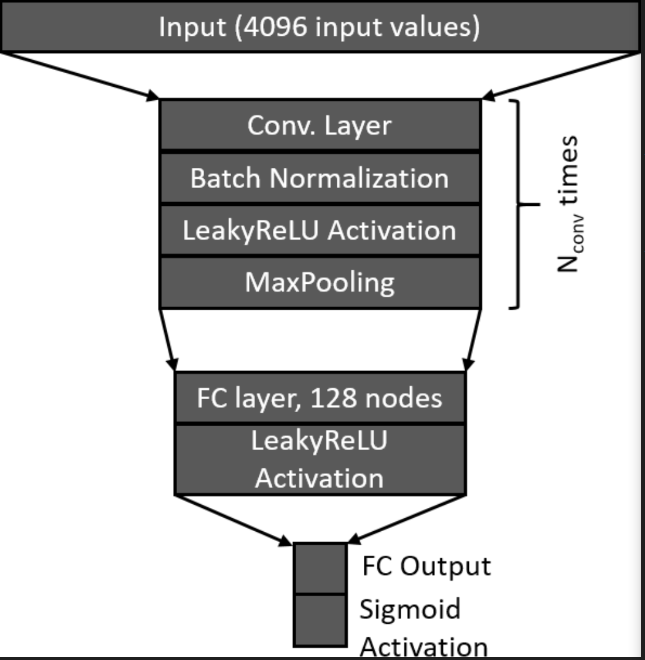

In [ ]:
l2_lambda = 0.01  

def cnn_model(input_shape,n_conv : int,conv_filters=32, conv_kernel=7,nodes = 128 ):
    inputs = tf.keras.Input(shape=input_shape)
    
    x= inputs
    
    for i in range(n_conv):
        x = tf.keras.layers.Conv1D(filters=conv_filters* (2**i), kernel_size=max(conv_kernel-i,3), strides=1, activation='linear',padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.05)(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=5,strides=2)(x)
        
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(nodes,activation='linear', kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.05)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
   
    classfication_output = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_output')(x)
    
   
    regression_output =  tf.keras.layers.Dense(1, activation='linear', name='regression_output')(x)
    
    
    model = tf.keras.Model(inputs=inputs, outputs=[classfication_output,regression_output])
    
    return model


input_shape = (X_train.shape[1], X_train.shape[2]) 

model = cnn_model(input_shape=input_shape, n_conv=4)

model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',  factor=0.5,  patience=5,  min_lr=1e-6, verbose=1)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2.8285e-05), #0.0001
              loss={'classification_output': 'binary_crossentropy','regression_output': 'mean_squared_error'},loss_weights={'classification_output': 1.0, 'regression_output': 0.7},metrics={'classification_output': 'accuracy', 'regression_output': 'mae'})


history = model.fit(X_train_scaled, {'classification_output': y_train_classification, 'regression_output': y_train_regression_scaled},validation_data=(X_test_scaled, {'classification_output': y_test_classification, 'regression_output': y_test_regression_scaled}),epochs=150, batch_size=64, callbacks=[early_stopping, reduce_lr])

test_loss, test_classification_loss, test_regression_loss, test_classification_accuracy, test_regression_mae = model.evaluate(X_test_scaled, {'classification_output': y_test_classification, 'regression_output': y_test_regression_scaled})


print(f"Test loss: {test_loss}")
print(f"Test Classification loss : {test_classification_loss}")
print(f"Test Regression loss: {test_regression_loss}")
print(f"Test Classification accuracy: {test_classification_accuracy}")
print(f"Test Regression MAE: {test_regression_mae}")


Save the model

In [38]:
model.save("files/my_model.keras")

Plotting the losses to recognize overfitting:
If the validation loss (e.g. val_loss) increases significantly while the training loss continues to fall, this means overfitting.

In [ ]:
def plot_training_history(history):

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['classification_output_loss'], label='Training Loss - Classification')
    plt.plot(history.history['val_classification_output_loss'], label='Validation Loss - Classification')
    plt.title('Classification Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['regression_output_loss'], label='Training Loss - Regression')
    plt.plot(history.history['val_regression_output_loss'], label='Validation Loss - Regression')
    plt.title('Regression Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
plot_training_history(history)

Load Data

In [40]:
with h5py.File('files/dataset.h5', 'r') as f:
    X_train = f['X_train'][:]
    y_train_classification = f['y_train_classification'][:]
    y_train_regression = f['y_train_regression'][:]
    X_test = f['X_test'][:]
    y_test_classification = f['y_test_classification'][:]
    y_test_regression = f['y_test_regression'][:]
    eval_data_feature = f['eval_data_feature'][:]
    eval_data_lable = f['eval_data_lable'][:]
    eval_data_lable_ce = f['eval_data_lable_ce'][:]
    X_train_scaled = f['X_train_scaled'][:]
    X_test_scaled = f['X_test_scaled'][:]
    eval_data_feature_scaled = f['eval_data_feature_scaled'][:]
    y_train_regression_scaled = f['y_train_regression_scaled'][:]
    y_test_regression_scaled = f['y_test_regression_scaled'][:]

# Laden der Scaler
scaler_X = joblib.load(scaler_X_path)
scaler_y = joblib.load(scaler_y_path)

Predict Data

In [ ]:
predictions = model.predict(X_test_scaled)
classification_preds = (predictions[0] > 0.7).astype(int)
regression_preds_scaled = predictions[1]
regression_preds = scaler_y.inverse_transform(regression_preds_scaled)

eval_prediction = model.predict(eval_data_feature_scaled)
eval_classification_preds = (eval_prediction[0] > 0.7).astype(int)
eval_regression_preds_scaled = eval_prediction[1] 
eval_regression_preds = scaler_y.inverse_transform(eval_regression_preds_scaled)

Plot a Confusion matrix to show the accuracy of the classification

In [ ]:
def plot_confusion_matrix(y_test_classification, classification_preds):
    
    conf_matrix = confusion_matrix(y_test_classification, classification_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, cmap="Blues", xticklabels=["class0", "class1"], yticklabels=["class0", "class1"], annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predictions")
    plt.ylabel("True Data")
    plt.show()


plot_confusion_matrix(y_test_classification, classification_preds)


In [ ]:
plot_confusion_matrix(eval_data_lable, eval_classification_preds)

Create a plot to show the accuracy of the regression prediction

In [ ]:
def compare_regression(y_test_regression, regression_preds):
    mse = mean_squared_error(y_test_regression, regression_preds)
    mae = mean_absolute_error(y_test_regression, regression_preds)
    print(f"MSE: {mse} \n MAE: {mae}")
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_regression, regression_preds, alpha=0.5)
    plt.plot([y_test_regression.min(), y_test_regression.max()], [y_test_regression.min(), y_test_regression.max()], 'r--', label="Ideal")
    plt.xlabel("True Value")
    plt.ylabel("Predictions")
    plt.ylim(-0.30, 0.30)
    plt.legend()
    plt.show()
    
compare_regression(y_test_regression, regression_preds) 

In [ ]:
compare_regression(eval_data_lable_ce, eval_regression_preds)